In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

Instead of web-scrapping images from Google, we will use the downloaded images of sports celebrities:
Maria Sharapova, Virat Kohli, Lionel Messi, Serena Williams, and Roger Federer. 

# 1. Preprocessing: Detect face and eyes

The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.

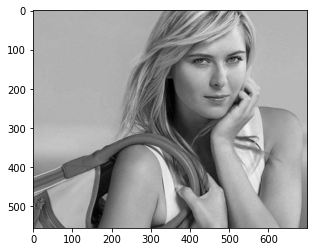

In [29]:
img = cv2.imread(r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/test_images/sharapova1.jpg')
img.shape

plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

gray

plt.imshow(gray, cmap = 'gray')


## Use haar cascade from opencv

### Haar cascade classifier is a machine learning object detection program that identifies objects in an image and video.

In [30]:
#load the required XML classifiers. 
# haar cascade files are available in OpenCV under XML extension.
face_cascade = cv2.CascadeClassifier(r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model//opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model//opencv/haarcascades/haarcascade_eye.xml')


###  Now we find the faces in the image. If faces are found, it returns the positions of detected faces as Rect(x,y,w,h). Once we get these locations, we can create a ROI (region of interest) for the face and apply eye dection on this ROI.

### For face detection/ detecting eyes, we will be using OpenCV, and for specific detection, we will be using the Haar cascade. 

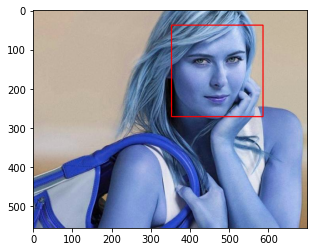

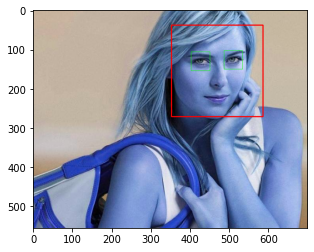

(233, 233, 3)

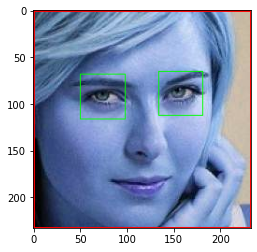

In [31]:

# haarcascade: allows to detect facial features.

faces = face_cascade.detectMultiScale(gray, 1.3, 5) #image, min size, max size 
faces
#this will output the location of face in the photo. Info is given in a coordinate structure in array.

(x,y,w,h) = faces[0]
x,y,w,h #x, y, width, height

#draw a rectangle around face using openCV.
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2) #img is the original image.
plt.imshow(face_img)

cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1) # image, start pt, end pt, color, thickness
    
    #select row starting with y till y+h & column starting with x till x+w. This works the same way with roi_color.
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),1)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

%matplotlib inline
plt.imshow(roi_color, cmap='gray') #roi is "region of image"

cropped_img = np.array(roi_color)
cropped_img.shape




In [32]:
faces[0]

array([352,  38, 233, 233], dtype=int32)


# Preprocessing

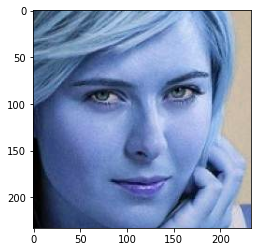

In [33]:
 
#Lets write a python function that can take input image and returns cropped image (ie. if face and eyes >=2 are detected)

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
        
cropped_image = get_cropped_image_if_2_eyes(r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model//test_images/sharapova1.jpg')
plt.imshow(cropped_image)

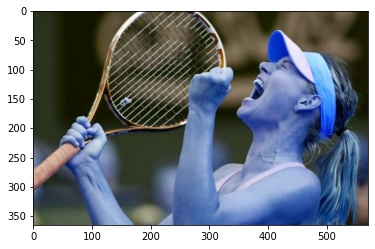

In [34]:
#In below image face is not very clear and it doesn't have two eyes clearly visible

org_image_obstructed = cv2.imread(r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/test_images/sharapova2.jpg')
plt.imshow(org_image_obstructed)


In [35]:


#Below cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

cropped_image_no_2_eyes = get_cropped_image_if_2_eyes(r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/test_images/sharapova2.jpg')
cropped_image_no_2_eyes


In [36]:
print(cropped_image_no_2_eyes)

None


In [37]:

path_to_data = r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/'
path_to_cr_data = r'/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/'


In [38]:

import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/maria_sharapova',
 '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/virat_kohli',
 '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/lionel_messi',
 '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/serena_williams',
 '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/roger_federer']

In [39]:
#Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after running this code.

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)


In [40]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder) #create a folder
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1


Generating cropped images in folder:  /Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova
Generating cropped images in folder:  /Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/virat_kohli
Generating cropped images in folder:  /Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/lionel_messi
Generating cropped images in folder:  /Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/serena_williams
Generating cropped images in folder:  /Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/roger_federer


In [43]:

#Manually examine cropped folder and delete any unwanted images

celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict


{'maria_sharapova': ['/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova2.png',
  '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova3.png',
  '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova1.png',
  '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova4.png',
  '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova5.png',
  '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova7.png',
  '/Users/user/Downloads/py-master/DataScience/CelebrityFaceRecognition/model/dataset/cropped/maria_sharapova/maria_sharapova6.png',
  '/Users/user/Downloads/py-master/DataScience/Cel

In [48]:

class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict


{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

# Preprocessing: Use wavelet transform as a feature for training our model


In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

## Wavelet transform

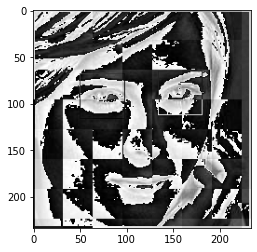

In [49]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#a wavelet transformed image gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier



## Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. 

In [50]:
X, y = [], [] #getting ready for training
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32)) #scale image to 32 x  32
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1))) #using numpy to vertically stack.
        X.append(combined_img)
        y.append(class_dict[celebrity_name])    #y is the name of celebrities 

len(X[0])
32*32*3 + 32*32

X[0]
y[0]

X = np.array(X).reshape(len(X), 4096).astype(float)



# Use SVM with rbf kernel tuned with heuristic finetuning.


In [51]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

print(classification_report(y_test, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.64      0.90      0.75        10
           2       0.78      0.64      0.70        11
           3       0.60      0.60      0.60        10
           4       0.80      0.57      0.67         7

    accuracy                           0.68        47
   macro avg       0.70      0.67      0.68        47
weighted avg       0.69      0.68      0.68        47



## Use GridSearch to try out different models with different parameters. Goal is to come up with best model with best fine tuned parameters.

In [52]:

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [53]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.771429,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.592857,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.778571,{'logisticregression__C': 1}


#### Logistic regression gives the best CV score. 

In [54]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [55]:

best_estimators['svm'].score(X_test,y_test)


0.6808510638297872

In [56]:

best_estimators['logistic_regression'].score(X_test,y_test)

0.7021276595744681

In [57]:

best_estimators['random_forest'].score(X_test,y_test)

0.574468085106383

#### Again, logistic regression gives the best scores on test dataset.


In [58]:

best_clf = best_estimators['logistic_regression']


In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[7, 0, 0, 2, 0],
       [1, 9, 0, 0, 0],
       [0, 0, 8, 2, 1],
       [3, 0, 0, 4, 3],
       [0, 1, 0, 1, 5]])

## Confusion Matrix

{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

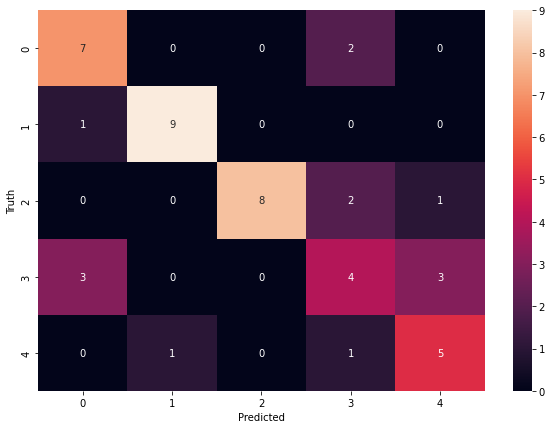

In [60]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

class_dict


#### Looking at the confusion matrix, our model predicted maria sharapova correctly 7 times out of 9, virat kohli 9 times out of 10,  8 times out of 11, serena williams 4 times out of 10, roger federer 5 times out of 7. Our model predicts the face of serena williams with lower accuracy than that of other sports celebrities; we need to double check the prepared image dataset (cropped version) and mannually delete irrelevant faces prior to running a model, as some cropped images were incorrectly identified as serena williams when generated via for loop in the beginning part of this project. (for example, our. get_cropped_image_if_2_eyes function selected the eyes/ faces of Serena williams' husband instead of her. and added the cropped image into our trainset.)


In [61]:
class_dict

{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

## Save the trained model & class dictionary

In [62]:
!pip install joblib

import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 



[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


['saved_model.pkl']

In [63]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))